<a href="https://colab.research.google.com/github/Raruu/Machine-Learning-2025/blob/main/JS06/JS06_Praktikum2_Hidayat_Widi_Saputra_2341720157.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Praktikum 2

Pada percobaan kali ini kita akan membuat pencarian sederhana menggunakan FAISS. Install FAISS terlebih dahulu menggunakan FAISS-CPU, jika ingin menggunakan GPU, dapat lakukan instalasi FAISS-GPU.

In [3]:
!pip install faiss-cpu -q
# !pip install faiss-gpu -q

Exact NN (Flat) indices: [[137 170 750]] distances: [[0.00013095 0.00077404 0.00079751]]
IVF+PQ indices: [[137 170 750]] distances: [[0.00012945 0.00079226 0.00080067]]
Waktu Exact: 0.0010039806365966797
Waktu IVF+PQ: 0.0010004043579101562


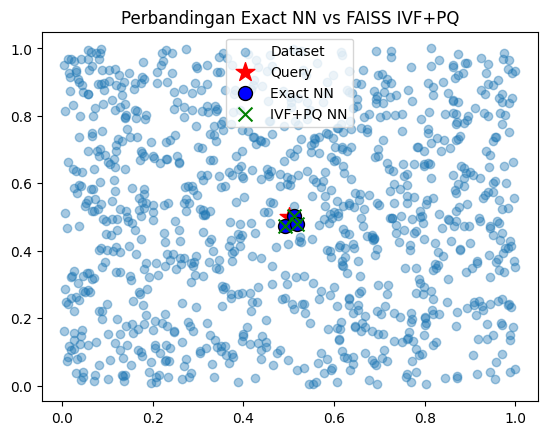

In [5]:
import numpy as np
import faiss
import matplotlib.pyplot as plt
import time

# 1. Buat dataset 2D sederhana
np.random.seed(42)
X = np.random.rand(1000, 2).astype('float32')  # 1000 titik 2D
query = np.array([[0.5, 0.5]], dtype='float32')  # query di tengah

# 2. Exact NN dengan IndexFlatL2 (brute force tapi cepat)
index_flat = faiss.IndexFlatL2(2)   # L2 = Euclidean distance
index_flat.add(X)

start = time.time()
D_flat, I_flat = index_flat.search(query, 3)  # cari 3 tetangga terdekat
end = time.time()
time_flat = end - start

# 3. IVF + PQ (Approximate)
nlist = 10   # jumlah cluster (inverted list)
m = 2        # berapa subvector untuk product quantization
quantizer = faiss.IndexFlatL2(2)   # dipakai IVF untuk cluster awal
index_ivfpq = faiss.IndexIVFPQ(quantizer, 2, nlist, m, 8)  # 8 bit per subvector

index_ivfpq.train(X)  # training centroid
index_ivfpq.add(X)

start = time.time()
D_ivfpq, I_ivfpq = index_ivfpq.search(query, 3)
end = time.time()
time_ivfpq = end - start

# 4. Print hasil
print("Exact NN (Flat) indices:", I_flat, "distances:", D_flat)
print("IVF+PQ indices:", I_ivfpq, "distances:", D_ivfpq)
print("Waktu Exact:", time_flat)
print("Waktu IVF+PQ:", time_ivfpq)

# 5. Visualisasi
plt.scatter(X[:,0], X[:,1], alpha=0.4, label="Dataset")
plt.scatter(query[:,0], query[:,1], c='red', marker='*', s=200, label="Query")

# Tetangga dari Flat
plt.scatter(X[I_flat[0],0], X[I_flat[0],1], c='blue', s=100, edgecolor='k', label="Exact NN")

# Tetangga dari IVF+PQ
plt.scatter(X[I_ivfpq[0],0], X[I_ivfpq[0],1], c='green', marker='x', s=100, label="IVF+PQ NN")

plt.legend()
plt.title("Perbandingan Exact NN vs FAISS IVF+PQ")
plt.show()


In [4]:
import numpy as np
import faiss
import time
import pandas as pd

def run_experiment(n_data, dim, metric_type):
    """
    Fungsi untuk menjalankan satu skenario eksperimen FAISS.

    Args:
        n_data (int): Jumlah titik data dalam dataset.
        dim (int): Dimensi dari setiap titik data.
        metric_type (str): 'L2' untuk Euclidean atau 'IP' untuk Inner Product.

    Returns:
        dict: Kamus berisi hasil metrik performa.
    """
    print(f"Running experiment: {n_data} data, {dim}D, Metric: {metric_type}...")

    # 1. Generate Dataset
    np.random.seed(42)
    X = np.random.rand(n_data, dim).astype('float32')
    query = np.random.rand(1, dim).astype('float32')
    k = 5  # Kita akan mencari 5 tetangga terdekat

    # Normalisasi data jika menggunakan Inner Product (penting untuk perbandingan seperti Cosine Similarity)
    if metric_type == 'IP':
        faiss.normalize_L2(X)
        faiss.normalize_L2(query)

    # 2. Exact NN (IndexFlat)
    if metric_type == 'L2':
        index_flat = faiss.IndexFlatL2(dim)
    else: # 'IP'
        index_flat = faiss.IndexFlatIP(dim)
    
    index_flat.add(X)
    start_time = time.time()
    D_flat, I_flat = index_flat.search(query, k)
    time_flat = time.time() - start_time

    # 3. Approximate NN (IndexIVFPQ)
    # Menentukan parameter yang masuk akal
    nlist = min(int(np.sqrt(n_data)), 256) # Jumlah cluster, dibatasi agar tidak terlalu banyak
    m = 1 if dim % 2 != 0 else 2 # Sub-quantizer, m harus bisa membagi dim
    if dim == 2: m=2 # Untuk 2D, m=2 lebih optimal
    if dim == 5: m=1 # Untuk 5D, m harus 1 atau 5

    if metric_type == 'L2':
        quantizer = faiss.IndexFlatL2(dim)
        index_ivfpq = faiss.IndexIVFPQ(quantizer, dim, nlist, m, 8)
    else: # 'IP'
        quantizer = faiss.IndexFlatIP(dim)
        # Untuk IP, metrik harus didefinisikan juga di quantizer
        index_ivfpq = faiss.IndexIVFPQ(quantizer, dim, nlist, m, 8, faiss.METRIC_INNER_PRODUCT)

    # Waktu Build (Train + Add)
    start_build = time.time()
    index_ivfpq.train(X[:min(n_data, 100000)]) # Training hanya butuh sampel data
    index_ivfpq.add(X)
    time_build = time.time() - start_build

    # Waktu Search
    index_ivfpq.nprobe = 5 # Berapa cluster tetangga yang akan dicari
    start_time = time.time()
    D_ivfpq, I_ivfpq = index_ivfpq.search(query, k)
    time_ivfpq = time.time() - start_time
    
    # 4. Hitung Recall (Akurasi)
    # Seberapa banyak tetangga terdekat yang benar ditemukan oleh metode approximate
    true_neighbors = set(I_flat[0])
    approx_neighbors = set(I_ivfpq[0])
    recall = len(true_neighbors.intersection(approx_neighbors)) / k

    return {
        "Ukuran Data": n_data,
        "Dimensi": dim,
        "Metrik Jarak": metric_type,
        "Waktu Build (IVFPQ) (s)": round(time_build, 6),
        "Waktu Search (Exact) (s)": round(time_flat, 6),
        "Waktu Search (IVFPQ) (s)": round(time_ivfpq, 6),
        f"Recall@{k}": recall
    }

# --- Main Execution ---
scenarios = [
    (1000, 2, 'L2'),
    (1000, 5, 'L2'),
    (1000000, 2, 'L2'),
    (1000000, 5, 'L2'),
    (1000, 2, 'IP'),
    (1000, 5, 'IP'),
    (1000000, 2, 'IP'),
    (1000000, 5, 'IP'),
]

results = []
for n_data, dim, metric in scenarios:
    results.append(run_experiment(n_data, dim, metric))

# Tampilkan hasil dalam tabel pandas
df_results = pd.DataFrame(results)
print("\n--- Hasil Eksperimen ---")
print(df_results.to_string())

Running experiment: 1000 data, 2D, Metric: L2...
Running experiment: 1000 data, 5D, Metric: L2...
Running experiment: 1000000 data, 2D, Metric: L2...
Running experiment: 1000000 data, 5D, Metric: L2...
Running experiment: 1000 data, 2D, Metric: IP...
Running experiment: 1000 data, 5D, Metric: IP...
Running experiment: 1000000 data, 2D, Metric: IP...
Running experiment: 1000000 data, 5D, Metric: IP...

--- Hasil Eksperimen ---
   Ukuran Data  Dimensi Metrik Jarak  Waktu Build (IVFPQ) (s)  Waktu Search (Exact) (s)  Waktu Search (IVFPQ) (s)  Recall@5
0         1000        2           L2                 0.004998                  0.000000                     0.000       1.0
1         1000        5           L2                 0.004001                  0.000000                     0.000       0.8
2      1000000        2           L2                 0.408952                  0.003002                     0.000       0.8
3      1000000        5           L2                 0.430403             

| Ukuran Data | Dimensi | Metrik Jarak | Waktu Build (IVFPQ) (s) | Waktu Search (Exact) (s) | Waktu Search (IVFPQ) (s) | Recall@5 |
| :---------: | :-----: | :----------: | :---------------------: | :----------------------: | :----------------------: | :------: |
|    1000     |    2    |      L2      |        0.004998         |         0.000000         |          0.000           |   1.0    |
|    1000     |    5    |      L2      |        0.004001         |         0.000000         |          0.000           |   0.8    |
|   1000000   |    2    |      L2      |        0.408952         |         0.003002         |          0.000           |   0.8    |
|   1000000   |    5    |      L2      |        0.430403         |         0.004002         |          0.000           |   0.2    |
|    1000     |    2    |      IP      |        0.005999         |         0.000000         |          0.000           |   0.4    |
|    1000     |    5    |      IP      |        0.004000         |         0.001001         |          0.000           |   0.2    |
|   1000000   |    2    |      IP      |        0.771267         |         0.002028         |          0.001           |   0.0    |
|   1000000   |    5    |      IP      |        0.693971         |         0.002999         |          0.000           |   0.0    |
